<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Player Track Box Score Stats Features</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Baseline-Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_rolling_player_track_box_stats_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.tail()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,0.677,0.635,0.221,0.385,0.543,0.486,0.52,0.510,0.867,0.730,0.574,0.717,0.417,0.442,0.578,0.740,0.693,0.669,0.489,0.502,0.622,0.200,0.563,0.362,0.554,0.375,0.429,0.551,0.525,0.440,0.514,0.573,0.555,0.296,0.785,0.751,0.413,0.569,0.430,0.646,218
2024-02-04,0.637,0.374,0.332,0.378,0.571,0.771,0.40,0.565,0.735,0.770,0.535,0.862,0.287,0.474,0.369,0.632,0.784,0.800,0.438,0.418,0.536,0.135,0.398,0.201,0.517,0.775,0.179,0.489,0.575,0.714,0.493,0.972,0.536,0.263,0.806,1.047,0.609,0.700,0.570,0.742,252
2024-02-04,0.589,0.452,0.289,0.378,0.444,0.543,0.56,0.411,0.592,0.500,0.426,0.611,0.557,0.564,0.663,0.727,0.614,0.593,0.485,0.582,0.654,0.471,0.347,0.362,0.529,0.100,0.500,0.511,0.408,0.595,0.500,0.799,0.336,0.275,0.491,0.653,0.478,0.446,0.725,0.558,210
2024-02-04,0.609,0.383,0.269,0.324,0.448,0.286,0.68,0.447,0.571,0.459,0.326,0.707,0.426,0.577,0.474,0.597,0.625,0.538,0.579,0.371,0.785,0.503,0.443,0.433,0.781,0.275,0.464,0.823,0.658,0.500,0.613,0.508,0.582,0.405,0.659,0.624,0.576,0.677,0.561,0.654,214
2024-02-04,0.486,0.609,0.344,0.491,0.396,0.286,0.32,0.368,0.561,0.351,0.233,0.653,0.643,0.756,0.641,0.710,0.443,0.483,0.454,0.560,0.726,0.335,0.381,0.307,0.688,0.425,0.250,0.744,0.500,0.512,0.507,0.662,0.282,0.227,0.477,0.559,0.663,0.746,0.545,0.431,222


In [5]:
pm_scaled_df.head()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.635,0.522,0.269,0.345,0.540,0.429,0.6,0.492,0.561,0.932,0.922,0.601,0.391,0.295,0.676,0.758,0.398,0.276,0.720,0.691,0.591,0.032,0.744,0.370,0.660,0.375,0.357,0.638,0.708,0.238,0.246,0.581,0.682,0.433,0.749,0.728,0.076,0.423,0.023,0.635,29.0
2021-10-23,0.588,0.565,0.407,0.564,0.429,0.143,0.8,0.313,0.612,0.257,0.225,0.511,0.696,0.679,0.761,0.753,0.909,1.000,0.352,0.745,0.665,0.613,0.119,0.252,0.530,0.250,0.714,0.531,0.500,0.595,0.704,0.564,0.409,0.190,0.738,0.704,0.620,0.423,1.000,0.577,7.0
2021-10-23,0.592,0.652,0.150,0.291,0.619,0.143,0.6,0.515,0.918,0.662,0.496,0.746,0.739,0.808,0.712,0.827,0.455,0.586,0.291,0.727,0.715,0.452,0.460,0.409,0.460,0.375,0.179,0.403,0.208,0.357,0.282,0.735,0.136,0.372,0.075,0.225,0.511,0.346,0.965,0.250,-10.0
2021-10-23,0.688,0.870,0.229,0.509,0.582,0.429,0.4,0.498,0.000,0.527,1.000,0.138,0.000,0.359,0.000,0.000,0.909,0.655,0.762,0.000,0.619,0.387,0.489,0.409,0.579,0.125,0.179,0.517,0.083,0.000,0.458,0.000,0.364,0.453,0.301,0.000,0.185,0.269,0.453,0.096,-8.0
2021-10-24,0.523,0.522,0.427,0.455,0.452,0.429,0.0,0.365,0.765,0.865,0.884,0.566,0.565,0.391,0.850,0.848,0.341,0.655,0.075,0.745,1.000,0.903,0.460,0.665,1.000,0.875,0.536,0.859,0.833,0.179,0.352,0.355,1.000,1.000,0.470,0.362,0.783,0.731,0.732,1.000,-10.0


In [6]:
res_scaled_df.tail()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,0.677,0.635,0.221,0.385,0.543,0.486,0.52,0.510,0.867,0.730,0.574,0.717,0.417,0.442,0.578,0.740,0.693,0.669,0.489,0.502,0.622,0.200,0.563,0.362,0.554,0.375,0.429,0.551,0.525,0.440,0.514,0.573,0.555,0.296,0.785,0.751,0.413,0.569,0.430,0.646,0
2024-02-04,0.637,0.374,0.332,0.378,0.571,0.771,0.40,0.565,0.735,0.770,0.535,0.862,0.287,0.474,0.369,0.632,0.784,0.800,0.438,0.418,0.536,0.135,0.398,0.201,0.517,0.775,0.179,0.489,0.575,0.714,0.493,0.972,0.536,0.263,0.806,1.047,0.609,0.700,0.570,0.742,0
2024-02-04,0.589,0.452,0.289,0.378,0.444,0.543,0.56,0.411,0.592,0.500,0.426,0.611,0.557,0.564,0.663,0.727,0.614,0.593,0.485,0.582,0.654,0.471,0.347,0.362,0.529,0.100,0.500,0.511,0.408,0.595,0.500,0.799,0.336,0.275,0.491,0.653,0.478,0.446,0.725,0.558,0
2024-02-04,0.609,0.383,0.269,0.324,0.448,0.286,0.68,0.447,0.571,0.459,0.326,0.707,0.426,0.577,0.474,0.597,0.625,0.538,0.579,0.371,0.785,0.503,0.443,0.433,0.781,0.275,0.464,0.823,0.658,0.500,0.613,0.508,0.582,0.405,0.659,0.624,0.576,0.677,0.561,0.654,0
2024-02-04,0.486,0.609,0.344,0.491,0.396,0.286,0.32,0.368,0.561,0.351,0.233,0.653,0.643,0.756,0.641,0.710,0.443,0.483,0.454,0.560,0.726,0.335,0.381,0.307,0.688,0.425,0.250,0.744,0.500,0.512,0.507,0.662,0.282,0.227,0.477,0.559,0.663,0.746,0.545,0.431,1


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [9]:
# configuration for total points with expanding window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
lr, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 2.62 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.29
- Null RMSE: 20.28


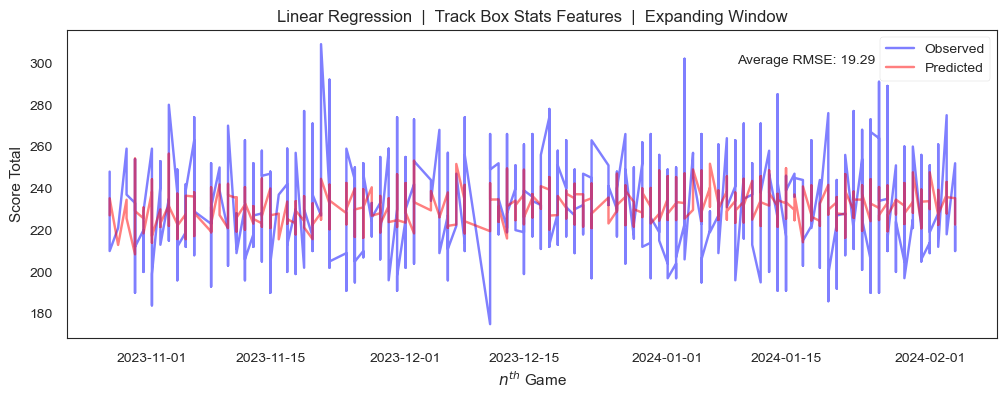

In [11]:
utl.plot_model_performance(
    title='Linear Regression  |  Track Box Stats Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [12]:
# configuration for total points with rolling window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 4.65 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.61
- Null RMSE: 19.88


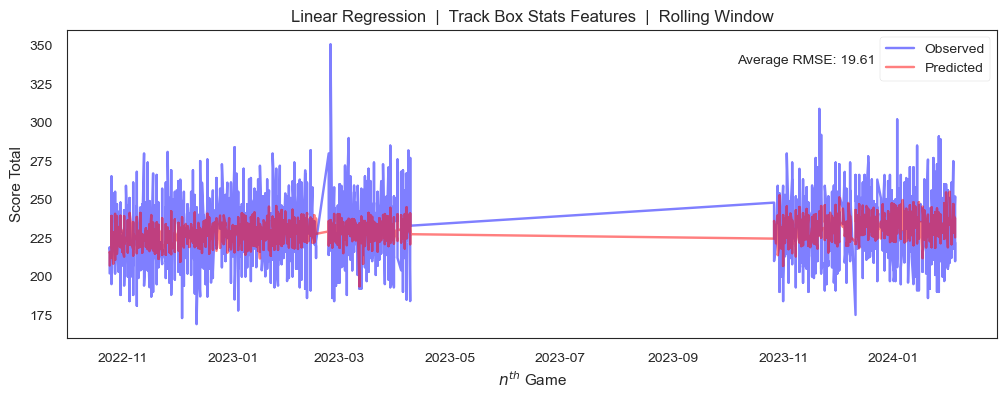

In [14]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Track Box Stats Features  |  Rolling Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [15]:
# configuration for point difference with expanding window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 2.39 seconds


In [16]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.46
- Null RMSE: 15.32


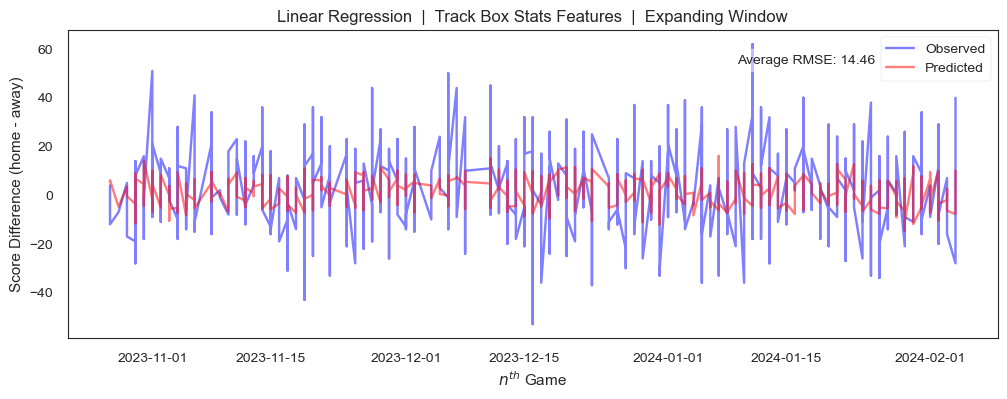

In [17]:
utl.plot_model_performance(
    title='Linear Regression  |  Track Box Stats Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [18]:
# configuration for points difference with rolling window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 4.57 seconds


In [19]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.92
- Null RMSE: 14.28


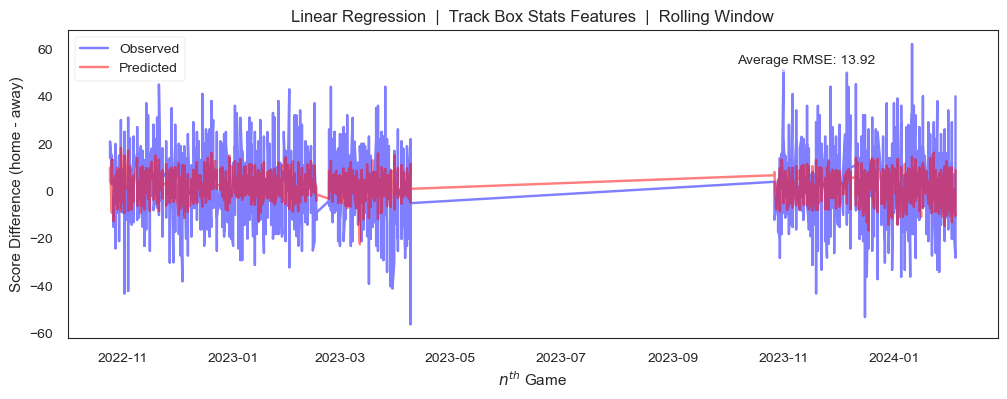

In [20]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Track Box Stats Features  |  Rolling Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [21]:
# configuration for game winner with expanding window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 23.00 seconds


In [22]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.56
- Average Accuracy: 0.64
- Overall AUC: 0.68
- Average F1 Score: 0.68


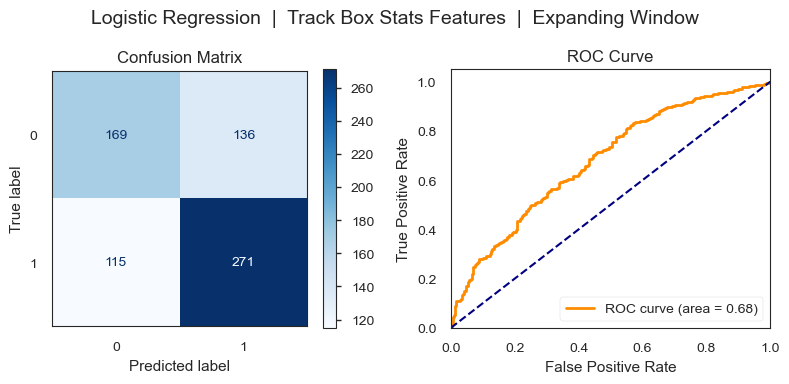

In [23]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Track Box Stats Features  |  Expanding Window'
)

In [24]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/GLM_preds_playertrack_stats.csv', index=False)

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [25]:
# configuration for game winner with rolling window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit,
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 73.07 seconds


In [26]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.57
- Average Accuracy: 0.61
- Overall AUC: 0.61
- Average F1 Score: 0.68


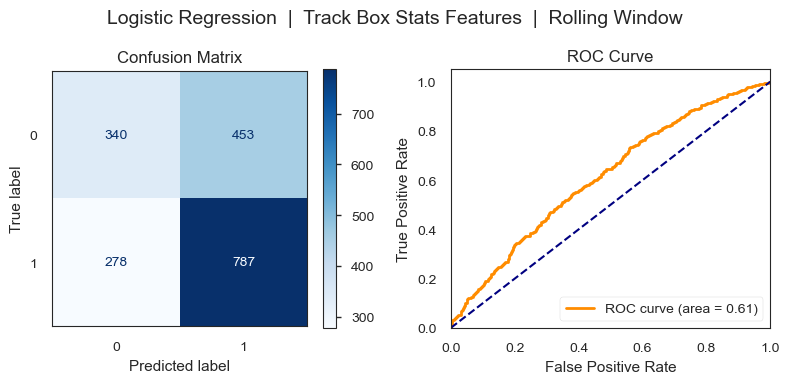

In [27]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Track Box Stats Features  |  Rolling Window'
)